# Generate Plaintext Baselines

Train and evaluate logistic regression baselines on the four synthetic datasets (32/88/93/181 dimensions).

In [ ]:
# Imports and configuration
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, brier_score_loss, precision_recall_curve, average_precision_score)

plt.style.use('seaborn-v0_8-paper')
sns.set_palette('deep')

DATA_DIR = Path('data/synthetic')
ARTIFACT_DIR = Path('artifacts/plaintext_baseline')
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)
DIMENSIONS = [
    {'name': '32-dim', 'folder': '32dim', 'description': 'Baseline acoustic'},
    {'name': '88-dim', 'folder': '88dim', 'description': 'eGeMAPS acoustic'},
    {'name': '93-dim', 'folder': '93dim', 'description': 'LIWC linguistic'},
    {'name': '181-dim', 'folder': '181dim', 'description': 'Multimodal acoustic+linguistic'}
]
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
print('Artifacts directory:', ARTIFACT_DIR.resolve())

Artifacts directory: /Users/eve/Documents/Projects/SCRAM/experiments/artifacts/plaintext_baseline


## Utility Functions

In [9]:
ERRSTATE_KWARGS = dict(divide='ignore', invalid='ignore', over='ignore') # Suppress warnings during model fitting and evaluation

def ensure_finite(label, array):
    if not np.all(np.isfinite(array)):
        raise ValueError(f'Non-finite values detected in {label}')


def load_dataset(folder_name):
    folder = DATA_DIR / folder_name
    X_train = np.load(folder / 'X_train.npy')
    X_test = np.load(folder / 'X_test.npy')
    y_train = np.load(folder / 'y_train.npy')
    y_test = np.load(folder / 'y_test.npy')

    ensure_finite(f'{folder_name} X_train', X_train)
    ensure_finite(f'{folder_name} X_test', X_test)
    ensure_finite(f'{folder_name} y_train', y_train)
    ensure_finite(f'{folder_name} y_test', y_test)
    return X_train, X_test, y_train, y_test


def train_log_reg(X_train, y_train):
    model = LogisticRegression(
        penalty='l2',
        C=1.0,
        solver='liblinear',
        random_state=RANDOM_SEED,
        max_iter=1000
    )
    with np.errstate(**ERRSTATE_KWARGS):
        model.fit(X_train, y_train)
    return model


def bootstrap_auc_ci(y_true, y_scores, n_boot=2000, alpha=0.05, random_state=None):
    """Bootstrap 95% CI for AUC."""
    rng = np.random.RandomState(random_state)
    n = len(y_true)
    aucs = []
    for _ in range(n_boot):
        idx = rng.randint(0, n, size=n)
        if len(np.unique(y_true[idx])) < 2:
            continue
        aucs.append(roc_auc_score(y_true[idx], y_scores[idx]))
    
    auc = roc_auc_score(y_true, y_scores)
    lower = np.percentile(aucs, 100 * (alpha/2))
    upper = np.percentile(aucs, 100 * (1 - alpha/2))
    return auc, (lower, upper)


def compute_pr_metrics(y_true, y_scores):
    """Precision-Recall AUC (Average Precision)."""
    ap = average_precision_score(y_true, y_scores)
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    return ap, precision, recall


def sensitivity_at_specificity(y_true, y_scores, target_specs=(0.8, 0.9)):
    """Sensitivity at fixed specificity operating points."""
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    specificity = 1.0 - fpr
    results = {}
    
    for sp in target_specs:
        idx = np.where(specificity >= sp)[0]
        if idx.size == 0:
            best_idx = np.argmax(specificity)
        else:
            best_idx = idx[-1]
        
        results[sp] = {
            'specificity': float(specificity[best_idx]),
            'sensitivity': float(tpr[best_idx]),
            'threshold': float(thresholds[best_idx]) if best_idx < len(thresholds) else None
        }
    return results

def evaluate_model(model, X_train, y_train, X_test, y_test):
    with np.errstate(**ERRSTATE_KWARGS):
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
        logits_test = X_test @ model.coef_.flatten() + model.intercept_[0]

    # Basic metrics
    auc_test, (auc_lower, auc_upper) = bootstrap_auc_ci(
        y_test, y_test_proba, n_boot=2000, random_state=RANDOM_SEED
    )
    pr_auc, precision, recall = compute_pr_metrics(y_test, y_test_proba)
    sens_at_spec = sensitivity_at_specificity(y_test, y_test_proba)
    
    metrics = {
        'auc_train': roc_auc_score(y_train, y_train_proba),
        'auc_test': auc_test,
        'auc_ci_lower': auc_lower,
        'auc_ci_upper': auc_upper,
        'pr_auc': pr_auc,
        'sens_at_spec_0.8': sens_at_spec[0.8]['sensitivity'],
        'sens_at_spec_0.9': sens_at_spec[0.9]['sensitivity'],
        'brier_test': brier_score_loss(y_test, y_test_proba),
        'logit_min_test': float(logits_test.min()),
        'logit_max_test': float(logits_test.max())
    }

    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    return metrics, {'fpr': fpr, 'tpr': tpr}, logits_test, y_test_proba


print('Helpers ready.')

Helpers ready.


## Train & Evaluate Across All Dimensionalities

In [4]:
aggregate_rows = []
roc_curves = []
artifact_records = []

for spec in DIMENSIONS:
    print(f"Processing {spec['name']} ({spec['description']})")
    X_train, X_test, y_train, y_test = load_dataset(spec['folder'])
    model = train_log_reg(X_train, y_train)
    metrics, roc_data, logits_test, y_test_proba = evaluate_model(
        model, X_train, y_train, X_test, y_test
    )

    dim_dir = ARTIFACT_DIR / spec['folder']
    dim_dir.mkdir(parents=True, exist_ok=True)
    np.save(dim_dir / 'coefficients.npy', model.coef_.flatten())
    np.save(dim_dir / 'test_logits.npy', logits_test)
    np.save(dim_dir / 'test_probabilities.npy', y_test_proba)
    with open(dim_dir / 'intercept.txt', 'w') as f:
        f.write(str(float(model.intercept_[0])))
    with open(dim_dir / 'metrics.json', 'w') as f:
        json.dump(metrics, f, indent=2)

    aggregate_rows.append({
        'Dataset': spec['name'],
        'Description': spec['description'],
        'Dimensionality': X_train.shape[1],
        'Train Samples': X_train.shape[0],
        'Test Samples': X_test.shape[0],
        'AUC (train)': metrics['auc_train'],
        'AUC (test)': metrics['auc_test'],
        'AUC CI Lower': metrics['auc_ci_lower'],
        'AUC CI Upper': metrics['auc_ci_upper'],
        'PR-AUC': metrics['pr_auc'],
        'Sens@Spec0.8': metrics['sens_at_spec_0.8'],
        'Sens@Spec0.9': metrics['sens_at_spec_0.9'],
        'Brier (test)': metrics['brier_test']
    })
    roc_curves.append({'label': spec['name'], **roc_data})
    artifact_records.append({
        'dataset': spec['name'],
        'coef_path': str((dim_dir / 'coefficients.npy').resolve()),
        'metrics_path': str((dim_dir / 'metrics.json').resolve()),
        'logits_path': str((dim_dir / 'test_logits.npy').resolve()),
        'proba_path': str((dim_dir / 'test_probabilities.npy').resolve())
    })

summary_df = pd.DataFrame(aggregate_rows)
summary_df

Processing 32-dim (Baseline acoustic)
Processing 88-dim (eGeMAPS acoustic)
Processing 88-dim (eGeMAPS acoustic)
Processing 93-dim (LIWC linguistic)
Processing 93-dim (LIWC linguistic)
Processing 181-dim (Multimodal acoustic+linguistic)
Processing 181-dim (Multimodal acoustic+linguistic)


,Dataset,Description,Dimensionality,Train Samples,Test Samples,AUC (train),AUC (test),AUC CI Lower,AUC CI Upper,PR-AUC,Sens@Spec0.8,Sens@Spec0.9,Brier (test)
0,32-dim,Baseline acoustic,32,1600,400,0.889248,0.902525,0.871846,0.928700,0.902529,0.830,0.680,0.127099
1,88-dim,eGeMAPS acoustic,88,1600,400,0.985420,0.976275,0.963334,0.987100,0.979750,0.960,0.935,0.059006
2,93-dim,LIWC linguistic,93,1600,400,0.983856,0.959600,0.941538,0.975962,0.957619,0.955,0.920,0.078756
3,181-dim,Multimodal acoustic+linguistic,181,1600,400,1.000000,0.996500,0.993319,0.998825,0.996498,1.000,1.000,0.026531


## Visualization

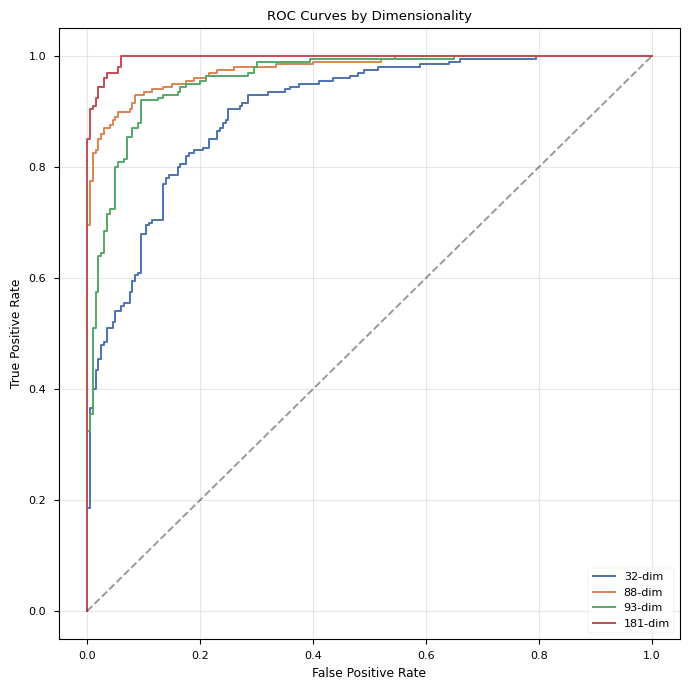

Saved ROC curves to /Users/eve/Documents/Projects/SCRAM/experiments/artifacts/plaintext_baseline


In [10]:
fig, ax = plt.subplots(figsize=(7, 7))
for roc in roc_curves:
    ax.plot(roc['fpr'], roc['tpr'], label=roc['label'])
ax.plot([0, 1], [0, 1], 'k--', alpha=0.4)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves by Dimensionality')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(ARTIFACT_DIR / 'roc_curves.png', dpi=150)
plt.show()
print('Saved ROC curves to', ARTIFACT_DIR.resolve())

## Aggregate Metrics

In [11]:
summary_df = pd.DataFrame(aggregate_rows)
summary_df.sort_values('Dimensionality')
summary_path = ARTIFACT_DIR / 'plaintext_baseline_summary.csv'
summary_df.to_csv(summary_path, index=False)
print('Saved summary to', summary_path)
display(summary_df)

with open(ARTIFACT_DIR / 'artifact_index.json', 'w') as f:
    json.dump(artifact_records, f, indent=2)
print('Artifact index recorded.')

Saved summary to artifacts/plaintext_baseline/plaintext_baseline_summary.csv


,Dataset,Description,Dimensionality,Train Samples,Test Samples,AUC (train),AUC (test),AUC CI Lower,AUC CI Upper,PR-AUC,Sens@Spec0.8,Sens@Spec0.9,Brier (test)
0,32-dim,Baseline acoustic,32,1600,400,0.889248,0.902525,0.871846,0.928700,0.902529,0.830,0.680,0.127099
1,88-dim,eGeMAPS acoustic,88,1600,400,0.985420,0.976275,0.963334,0.987100,0.979750,0.960,0.935,0.059006
2,93-dim,LIWC linguistic,93,1600,400,0.983856,0.959600,0.941538,0.975962,0.957619,0.955,0.920,0.078756
3,181-dim,Multimodal acoustic+linguistic,181,1600,400,1.000000,0.996500,0.993319,0.998825,0.996498,1.000,1.000,0.026531


Artifact index recorded.


## Statistical Summary

Evaluation with bootstrap confidence intervals, PR-AUC, and operating point analysis.

In [12]:
# Display AUC with 95% bootstrap CIs
print("AUC Performance with 95% Bootstrap Confidence Intervals:\n")
for _, row in summary_df.iterrows():
    print(f"{row['Dataset']:8s}: AUC = {row['AUC (test)']:.4f} "
          f"[{row['AUC CI Lower']:.4f}, {row['AUC CI Upper']:.4f}]  "
          f"(PR-AUC = {row['PR-AUC']:.4f})")

print("\n" + "="*70)
print("\nOperating Point Analysis (Sensitivity @ Fixed Specificity):\n")
for _, row in summary_df.iterrows():
    print(f"{row['Dataset']:8s}: "
          f"Sens@Spec=0.8: {row['Sens@Spec0.8']:.3f}  |  "
          f"Sens@Spec=0.9: {row['Sens@Spec0.9']:.3f}")

# Save enhanced summary
enhanced_summary_path = ARTIFACT_DIR / 'plaintext_baseline_enhanced_summary.csv'
summary_df.to_csv(enhanced_summary_path, index=False)
print(f"\n✓ Saved enhanced summary to {enhanced_summary_path}")

AUC Performance with 95% Bootstrap Confidence Intervals:

32-dim  : AUC = 0.9025 [0.8718, 0.9287]  (PR-AUC = 0.9025)
88-dim  : AUC = 0.9763 [0.9633, 0.9871]  (PR-AUC = 0.9798)
93-dim  : AUC = 0.9596 [0.9415, 0.9760]  (PR-AUC = 0.9576)
181-dim : AUC = 0.9965 [0.9933, 0.9988]  (PR-AUC = 0.9965)


Operating Point Analysis (Sensitivity @ Fixed Specificity):

32-dim  : Sens@Spec=0.8: 0.830  |  Sens@Spec=0.9: 0.680
88-dim  : Sens@Spec=0.8: 0.960  |  Sens@Spec=0.9: 0.935
93-dim  : Sens@Spec=0.8: 0.955  |  Sens@Spec=0.9: 0.920
181-dim : Sens@Spec=0.8: 1.000  |  Sens@Spec=0.9: 1.000

✓ Saved enhanced summary to artifacts/plaintext_baseline/plaintext_baseline_enhanced_summary.csv
